In [122]:
import pandas as pd
import random 
import string 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from scipy.stats import f

Вынесем создание некторых признаков в отдельные методы:

In [123]:
# Функция для создания user_id 
def create_id() -> str:
    symbols = string.digits + 'abcdefghigk'
    length = 15 
    id_combination = ''.join(random.choices(symbols, k=length))
    return id_combination

# Функция для создания total_cost
def create_total_cost() -> np.ndarray:
    lambda_param = 1  
    shift = +1   
    samples = np.random.exponential(scale=1/lambda_param, size=10000) + shift
    return samples

# Фунция для создания retention 
def create_retention() -> list:
    values = [1, 2, 3, 4, 5]
    probabilities = [0.35, 0.25, 0.2, 0.15, 0.05]
    samples = np.random.choice(values, size=10000, p=probabilities)
    return samples
    

Создаем начальные признаки с заданными по условию распределениями:

In [124]:
np.random.seed(228)
random.seed(0)

df = pd.DataFrame({
    'user_id': [create_id() for _ in range(10000)],
    'order_number': [random.randint(1, 10) for _ in range(10000)],
    'delivery_time': [random.normalvariate(1440, 200) for _ in range(10000)],
    'total_cost': create_total_cost(),
    'retention': create_retention()
})

df.head()

,user_id,order_number,delivery_time,total_cost,retention
0,hf85a8g6acga5fc,5,1468.130535,1.551319,2
1,5gkhi6fie929cgk,1,1714.039812,1.780325,5
2,ai5gb0f8he0ai56,7,1274.095548,2.166532,1
3,i4b5kg916ag2beb,7,1459.736531,1.424775,1
4,hbkcc9c8c633cda,9,1617.654541,1.578086,2


In [125]:
# Проверяем наличие дублей в id 
len(df['user_id'].unique()) == len(df)

True

In [126]:
# Указываем среднее время доставки для каждой группы заказов
df.groupby('order_number').agg(
    mean_delivery_time = ('delivery_time', 'mean')
).reset_index()

,order_number,mean_delivery_time
0,1,1443.067312
1,2,1436.941624
2,3,1447.769069
3,4,1434.804670
4,5,1442.662351
5,6,1441.404784
6,7,1443.004300
7,8,1434.579128
8,9,1445.069715
9,10,1438.939390


Для каждого заказа в таблице добавим среднее время доставки по группе, к которой относиться данный заказ 

In [127]:
df['mean_delivery_time'] = df.groupby('order_number')['delivery_time'].transform('mean')

df.head()

,user_id,order_number,delivery_time,total_cost,retention,mean_delivery_time
0,hf85a8g6acga5fc,5,1468.130535,1.551319,2,1442.662351
1,5gkhi6fie929cgk,1,1714.039812,1.780325,5,1443.067312
2,ai5gb0f8he0ai56,7,1274.095548,2.166532,1,1443.004300
3,i4b5kg916ag2beb,7,1459.736531,1.424775,1,1443.004300
4,hbkcc9c8c633cda,9,1617.654541,1.578086,2,1445.069715


Разделим группы на сегменты:

In [128]:
df['segment'] = pd.qcut(df['order_number'], q=4, labels=['1-3', '4-6', '6-9', '10'])
df

,user_id,order_number,delivery_time,total_cost,retention,mean_delivery_time,segment
0,hf85a8g6acga5fc,5,1468.130535,1.551319,2,1442.662351,4-6
1,5gkhi6fie929cgk,1,1714.039812,1.780325,5,1443.067312,1-3
2,ai5gb0f8he0ai56,7,1274.095548,2.166532,1,1443.004300,6-9
3,i4b5kg916ag2beb,7,1459.736531,1.424775,1,1443.004300,6-9
4,hbkcc9c8c633cda,9,1617.654541,1.578086,2,1445.069715,10
...,...,...,...,...,...,...,...
9995,fa8ffbb9b0d29g7,6,1716.504545,1.420788,3,1441.404784,4-6
9996,gggc6dh8h868gd9,4,1571.202548,1.649972,1,1434.804670,4-6
9997,5gg66db99ch6361,8,1134.459021,1.861121,2,1434.579128,6-9
9998,akh9he4cgd01i5k,9,1001.841827,1.712825,3,1445.069715,10


Посмотрим распределение стоимости заказа:

In [129]:
fig = px.box(df, y=df['total_cost'])
fig.show()

Box-plot показывает достаточно большое количество выбросов, так как распределение экспоненциальное

Теперь сформируем статистику по стоимости заказа: 

In [130]:
total_cost_mode = stats.mode(df['total_cost'])
total_cost_mean = np.mean(df['total_cost'])
total_cost_median = np.median(df['total_cost'])
total_cost_variance = np.var(df['total_cost'])
total_cost_std = np.std(df['total_cost'])

In [131]:
print('Статистика по столбцу total_cost:')
print('=================================')
print(f'Среднее: {total_cost_mean}')
print(f'Мода: {total_cost_mode}')
print(f'Медиана: {total_cost_median}')
print(f'Дисперсия: {total_cost_variance}')
print(f'Стандартное отклонение: {total_cost_std}')

Статистика по столбцу total_cost:
Среднее: 1.991942147341637
Мода: ModeResult(mode=1.000080556966821, count=1)
Медиана: 1.6933069979581625
Дисперсия: 0.9702400359263662
Стандартное отклонение: 0.9850076324203616


Агрегируем данные для столбчатой диаграммы:

In [132]:
categories = sorted(df['order_number'].unique())
values = df.groupby('order_number')['delivery_time'].mean()
categories

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [133]:
fig = go.Figure(data=[
    go.Bar(
        x=categories, 
        y=values,
        text=values,
        textposition='outside',  
        texttemplate='%{text:.2f}',  
        marker_color='lightblue',
    )
])

# Настраиваю масштаб для лучшего отображения 
y_range_min = min(values) - (max(values) - min(values)) * 0.15
y_range_max = max(values) + (max(values) - min(values)) * 0.15

fig.update_layout(
    height=600,
    yaxis=dict(
        range=[y_range_min, y_range_max],
        tickformat=',.2f' 
    ),
    title={
        'text': 'Время доставки по номерам заказа',
        'x': 0.5,  
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}
    },
    margin=dict(t=50, b=50, l=50, r=50) 
)

fig.show()

Построим матрицу гистограмм распределения времени доставки для каждого типа заказа:

In [134]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig = make_subplots(rows=5, cols=2, 
                   subplot_titles=[f'Заказ {i}' for i in range(1, 11)],
                   vertical_spacing=0.08)

for i in range(1, 11):
    try:
        group_data = df.groupby('order_number')['delivery_time'].get_group(i)
        
        hist_fig = px.histogram(x=group_data, nbins=30, color_discrete_sequence=[colors[i-1]])
        
        for trace in hist_fig.data:
            fig.add_trace(trace, row=(i-1)//2 + 1, col=(i-1)%2 + 1)
        
        counts, bins = np.histogram(group_data, bins=15)
        max_count_idx = np.argmax(counts)
        max_bin_center = (bins[max_count_idx] + bins[max_count_idx + 1]) / 2
        
        fig.add_trace(go.Scatter(
            x=[max_bin_center, max_bin_center],
            y=[0, counts[max_count_idx]],
            mode='lines',
            line=dict(color='red', width=3, dash='dash'),
            name=f'Максимум {i}',
            showlegend=False
        ), row=(i-1)//2 + 1, col=(i-1)%2 + 1)
        
    except KeyError:
        continue

fig.update_layout(
    title_text='Матрица гистограмм распределения времени доставки по заказам',
    title_x=0.5,
    height=1200,
    showlegend=False
)

for i in range(1, 11):
    fig.update_xaxes(title_text='Время доставки', row=(i-1)//2 + 1, col=(i-1)%2 + 1)
    fig.update_yaxes(title_text='Количество', row=(i-1)//2 + 1, col=(i-1)%2 + 1)

fig.show()

Найдем на сколько в среднем отличается время доставки для каждого типа заказа:

In [135]:
total_delivery_time = 0 
for i in range(1, 11):
    total_delivery_time += (df['delivery_time'].mean() - df.groupby('order_number')['delivery_time'].get_group(i).mean())**2
    
print(np.sqrt(total_delivery_time/10))


4.166928417931011


Подготовим наши данные к кластеризации. Соберем исходные признаки в точки на плоскости:

In [136]:
data_x = np.array([(x, y) for x, y in zip(df['delivery_time'], df['total_cost'])])

Стандартизируем признаки и подберем оптимальное число кластеров с помощью метода Локтя:

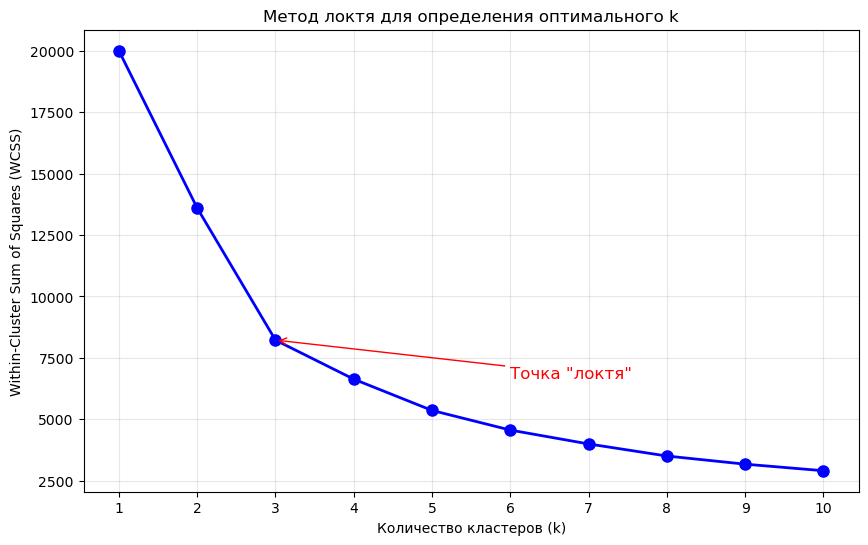

In [137]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_x)

def elbow_method(X, max_k=10):

    inertia = []
    k_range = range(1, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    return k_range, inertia

k_range, inertia = elbow_method(X_scaled, max_k=10)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

plt.annotate('Точка "локтя"', 
             xy=(3, inertia[2]), 
             xytext=(6, inertia[3] + 50),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=12, color='red')

plt.show()

Реализация классического K-Means со случаной инициализацией начальных кластеров:

In [138]:
np.random.seed(228)

M = np.mean(data_x, axis=0)      
D = np.var(data_x, axis=0)       
K = 3                      
ma = [data_x[i] for i in np.random.choice(len(data_x), K, replace=False)] # инициализация начальных центров 
N = 100  

# def p(ma, x_i):
#     return np.mean(np.abs(np.array(ma)-np.array(x_i)))

def centroid_recalc(cluster, index):
    if len(cluster) > 0:
        total_x = []
        total_y = []
        for x, y in cluster:
            total_x.append(x)
            total_y.append(y)
        return (np.mean(total_x), np.mean(total_y))
    else:
        return ma[index]
        
def p(ma, x_i):
    return np.sqrt((ma[0]-x_i[0])**2+(ma[1]-x_i[1])**2)

history = []

for i in range(N):
    clusters = [
        [], 
        [], 
        []
    ]
    cluster_labels = []
    
    for x in data_x:
        x_distances = {0: p(ma[0], x), 1: p(ma[1], x), 2: p(ma[2], x)}
        min_distance = x_distances[0]
        k = 0
        for k_index, x_distance in x_distances.items():
            if x_distance < min_distance:
                min_distance = x_distance
                k = k_index
        clusters[k].append(x) 
        cluster_labels.append(k)

    history.append({
        'centroids': ma.copy(),
        'labels': cluster_labels.copy()
    })
    
    ma = [centroid_recalc(clusters[0], 0), centroid_recalc(clusters[1], 1), centroid_recalc(clusters[2], 2)]

Построим scatter-plot, чтобы визуализировать наши кластеры:

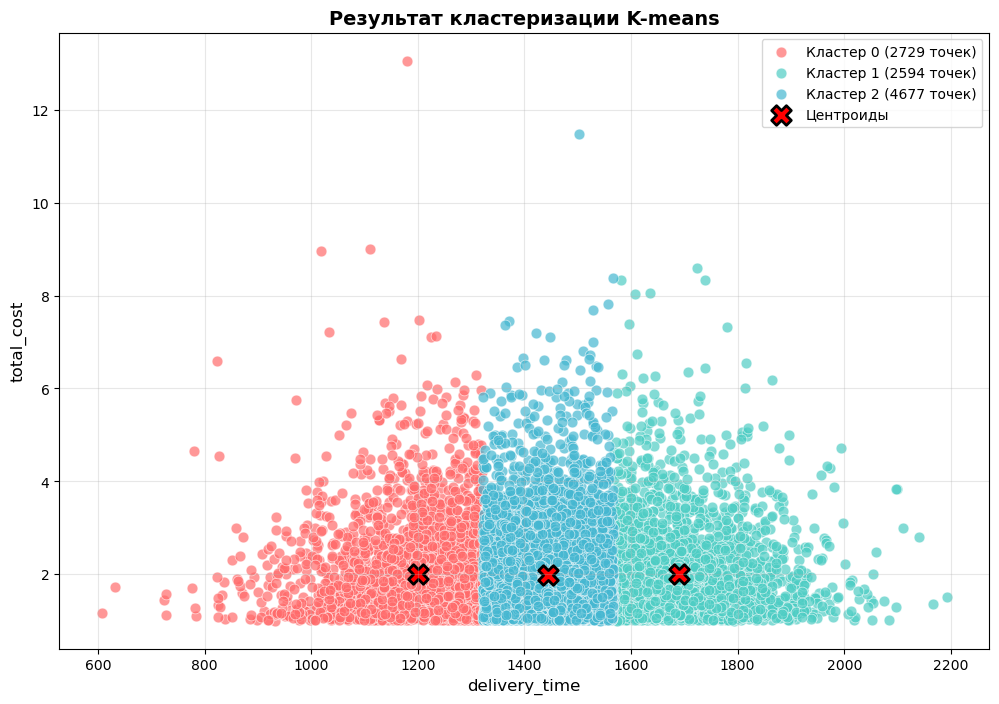

In [139]:
plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, cluster in enumerate(clusters):
    if len(cluster) > 0:
        cluster_array = np.array(cluster)
        plt.scatter(cluster_array[:, 0], cluster_array[:, 1], 
                   color=colors[i], s=60, alpha=0.7, 
                   label=f'Кластер {i} ({len(cluster)} точек)',
                   edgecolors='white', linewidth=0.5)

centroids_array = np.array(ma)
plt.scatter(centroids_array[:, 0], centroids_array[:, 1], 
           color='red', s=200, marker='X', 
           label='Центроиды', edgecolors='black', linewidth=2)

plt.xlabel('delivery_time', fontsize=12)
plt.ylabel('total_cost', fontsize=12)
plt.title('Результат кластеризации K-means', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

У нас получилось сформировать 3 кластера. Данная кластеризация позволяет определить следующую смысловую нагрузку для каждого кластера:
1. Кластер 0. Клиенты, которые живут неподалеку от склада
2. Кластер 1. Клиенты, которые живут не так далеко от склада 
3. Кластер 2. Клиенты, которые живут далеко от склада 

Теперь используем более совершенный алгоритм кластеризации K-Means++, который инициализирует начальные центры таким образом, чтобы они были наиболее удалены друг от друга, а также использует более точную метрику расстояния для обхода локальных минимумов. Реализуем через библиотеку sclearn.

Функция потерь: 

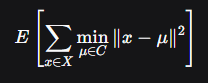

минимзируем внутрикластерное расстояние

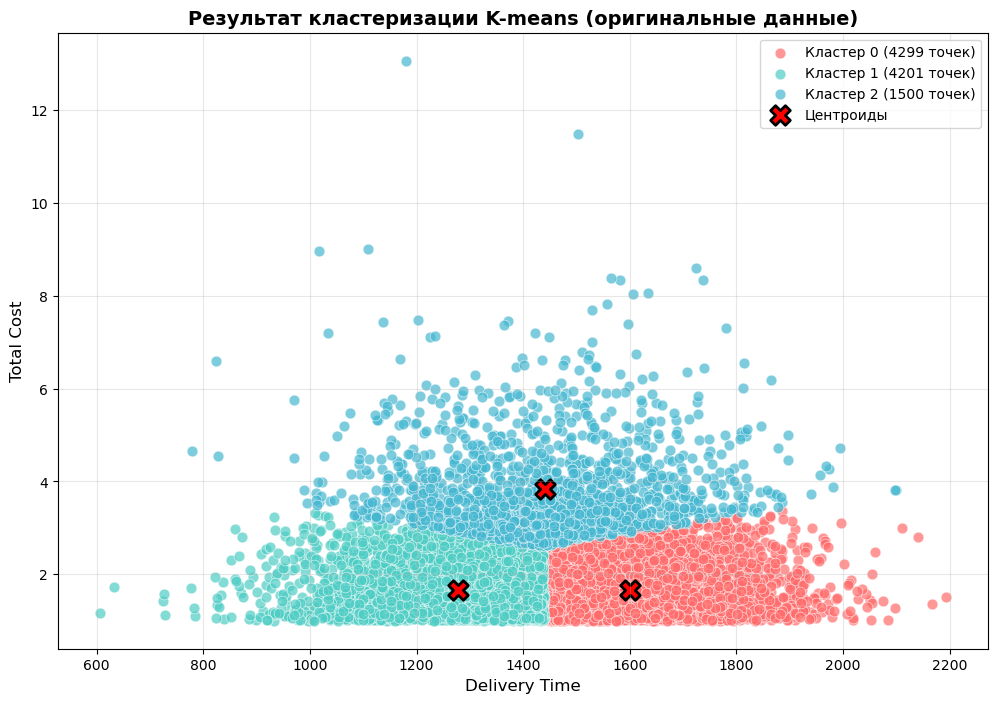

In [140]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for cluster_num in range(3):
    cluster_points = data_x[df['cluster'] == cluster_num]  
    if len(cluster_points) > 0:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   color=colors[cluster_num], s=60, alpha=0.7, 
                   label=f'Кластер {cluster_num} ({len(cluster_points)} точек)',
                   edgecolors='white', linewidth=0.5)

centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], 
           color='red', s=200, marker='X', 
           label='Центроиды', edgecolors='black', linewidth=2)

plt.xlabel('Delivery Time', fontsize=12)
plt.ylabel('Total Cost', fontsize=12)
plt.title('Результат кластеризации K-means (оригинальные данные)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Потрясающе! Мы получили совсем другие кластеры. Значит K-Means инициализировал центры слишком близко друг к другу, либо подвела метрика расстояния. Интерпретируем полученные кластеры: 
1. Кластер 0. Группа клиентов, которые живут далеко от склада и делают относительно недорогие покупки. 
2. Кластер 1. Группа клиентов, которые живут близко от склада, быстро забирая заказы, но делают относительно недорогие покупки. 
3. Кластер 2. Группа клиентов, которые делают хорошие по стоимости заказы и не испытывают сильных задержек в доставке. (основная выручка)

Хорошо. После того, как мы разделили на кластеры наши данные, выборочно сравним какие нибудь 2 кластера и убедимся в том, что различия между ними статистически значимы. Для этого воспользуемся Hotelling's T^2 статистикой:

Основной принцип - расстояние махаланобиса:


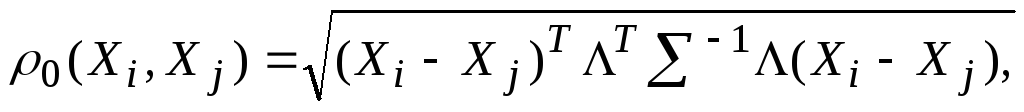

Данная метрика позволяет сказать: с какой вероятностью точка относиться к кластеру, учитывая вариативность каждого признака? Суть в том, что визуально равноудаленные от центра кластера точки на самом деле не с равной вероятностью могут быть причислены к одному и тому же кластеру. На картинке все точки на эллипсе имеют одинаковое расстояние махаланобиса - и как следствие равновероятно могут быть причисленны к кластеру.

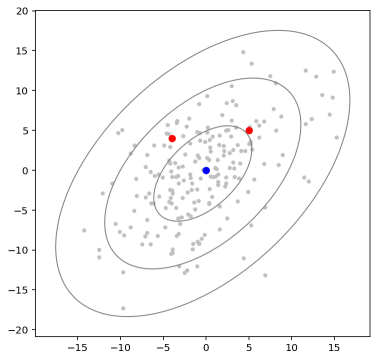




Где это используется в данном тесте? Все просто:

статистика T^2 = Расстояние Махаланобиса между центроидами кластеров + Стастическая поправка на размеры выборок 

Рассмотрим детальнее:

Инициализируем кластеры и описываем размерность данных:

In [141]:
X1 = np.array(clusters[0])  
X2 = np.array(clusters[1])

n1, p = X1.shape
n2, _ = X2.shape

Найдем центроиды для каждого кластера и вектор разницы между ними:

In [142]:
# 1. Вектора средних
mean1 = np.mean(X1, axis=0)
mean2 = np.mean(X2, axis=0)
diff = mean1 - mean2

print(f"Средние кластер 1: {mean1}")
print(f"Средние кластер 2: {mean2}") 
print(f"Разница: {diff}")

Средние кластер 1: [1199.50503371    1.994411  ]
Средние кластер 2: [1689.18606441    1.99297379]
Разница: [-4.89681031e+02  1.43721094e-03]


Смысл: "сырая разница" между центрами кластеров без учёта вариативности признаков




Опишем форму наших кластеров с помощью матриц ковариаций признаков:

In [143]:
# 2. Ковариационные матрицы
S1 = np.cov(X1, rowvar=False)
S2 = np.cov(X2, rowvar=False)

Объединенная ковариационная матрица - "Усредненная" ориентация обоих кластеров: 

In [144]:
S_pooled = ((n1-1)*S1 + (n2-1)*S2) / (n1 + n2 - 2)  

Обратная объединенная ковариационная матрица.

Смысл: "оператор коррекции расстояния", который:
1) учитывает вариативность признаков 
2) учитывает корреляции между признаками 
3) "сжимает" направления с большой дисперсией 
4) "растягивает" направления с малой дисперсией 

In [145]:
S_inv = np.linalg.inv(S_pooled) 

Статистический множитель.

Смысл: увеличивает метрику при больших выборках и понижает при малых. Надежность выборочного среднего определяется размером выборки. 

In [146]:
scaler = (n1 * n2) / (n1 + n2) # коэффицент, учитывающий размеры выборки 

Расчет статистики T²:

Смысл: Показывает насколько значимо различаются центры кластеров ОТНОСИТЕЛЬНО их естественного разброса и с учетом размеров выборок

In [151]:
# 3. T² статистика
mahalanobis_between_means = diff.T @ S_inv @ diff # расстояние махаланобиса между центроидами кластеров 
T2 = scaler * mahalanobis_between_means # преобразование исходной разницы в "взвешенную" с учетом вариативности данных 

print(f"\nT² статистика: {T2}")


T² статистика: 31315.186770949404


Преобразуем в F-распределение для оценки:

In [150]:
# 4. F-статистика
F_stat = (n1 + n2 - p - 1) / ((n1 + n2 - 2) * p) * T2
p_value = 1 - f.cdf(F_stat, p, n1 + n2 - p - 1)

print(f"F-статистика: {F_stat:.4f}")
print(f"p-value: {p_value}")

F-статистика: 15654.6508
p-value: 1.1102230246251565e-16


p-value меньше уровня значимости - следовательно различия между кластерами статистически значимые. 